<a href="https://colab.research.google.com/github/aaghouse/Cybersecurity_ML/blob/main/cyber_ml_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#inux = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Linux_disk.csv')
#win7 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Windows_7.csv')
#win10 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Windows_10.csv')
#gps = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_IoT_GPS_Tracker.csv')
#linuxmem = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Linux_memory.csv')
#linuxproc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/train_Test_Linux_process.csv')
network = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Network.csv')
#linux.head()
#win7.head()
#win10.head()
#gps.head()
#linuxmem.head()
#linuxproc.head()
network.tail()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
461038,1556340862,192.168.1.32,33108,176.28.50.165,80,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,1,xss
461039,1556423390,192.168.1.33,37242,34.230.157.88,443,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,1,ransomware
461040,1556436603,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,...,0,0,-,-,-,-,-,-,1,backdoor
461041,1556540442,192.168.1.31,60816,104.98.29.100,443,tcp,-,23.190902,32,31,...,0,0,-,-,-,-,-,-,1,mitm
461042,1556540442,192.168.1.31,41054,151.101.24.64,443,tcp,-,22.872314,32,31,...,0,0,-,-,-,-,-,-,1,mitm


In [46]:
#print(linux.isnull().sum()) # insnull() checks out no nulls.
#print(linux.eq(0).sum()) #?
#print(linux.shape) # no of records in the linux dataframe 160,112 and 9 features.
#print(linux.info())
#print(linux['type'].value_counts())
#print(linux['label'].value_counts())
#print(win7['type'].value_counts())
#print(win10['type'].value_counts())
#print(gps['type'].value_counts())
#print(linuxmem['type'].value_counts())
#print(linuxproc['type'].value_counts())
print(network['type'].value_counts())

normal        300000
scanning       20000
dos            20000
injection      20000
ddos           20000
password       20000
xss            20000
ransomware     20000
backdoor       20000
mitm            1043
Name: type, dtype: int64


In [47]:
print(network.columns)

Index(['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')


In [48]:
# All include libraries and modules are in this section of the code.
!pip install maxminddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import maxminddb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler#, PolynomialFeatures
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [49]:
# This code reviews the input source and destination IP's and maps it to the respective region where it originated or destined
# Eventually used to display as graph. This is to review any suspitious countries intrution right off the EDA phase to flag as
# a security threat. Example of these red flag regions could include Russia, Iran, China or other black listed countries for unknown/unwarrented traffic.


mmdb_file_path = '/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/GeoLite2-Country.mmdb'

# Open the MMDB file
with maxminddb.open_database(mmdb_file_path) as reader:
    # Load your DataFrame or create one with IP addresses
    # For example, let's assume you have a DataFrame with an 'ip_address' column
    # df = pd.read_csv('your_data.csv')

    # Function to perform IP address lookup and return location information
    def ip_to_location(ip):
        try:
            result = reader.get(ip)
            if result:
                return {
                    'country': result.get('country', {}).get('iso_code')#, 'N/A')
                    #'country': result.get('country', {}).get('iso_code', 'N/A')#,
                    #'city': result.get('city', {}).get('names', {}).get('en', 'N/A'),
                    #'latitude': result.get('location', {}).get('latitude', 'N/A'),
                    #'longitude': result.get('location', {}).get('longitude', 'N/A')
                }
            else:
                return {'country': 'N/A'}#, 'city': 'N/A', 'latitude': 'N/A', 'longitude': 'N/A'}
        except Exception as e:
            return {'country': 'N/A'}#, 'city': 'N/A', 'latitude': 'N/A', 'longitude': 'N/A'}

    # Apply the 'ip_to_location' function to the DataFrame to create new columns
    network['src_country'] = network['src_ip'].apply(ip_to_location)
    network['dst_country'] = network['dst_ip'].apply(ip_to_location)
#print(network['src_country'])

network['src_country'] = network['src_country'].apply(lambda x: x.get('country', 'N/A'))
network['dst_country'] = network['dst_country'].apply(lambda x: x.get('country', 'N/A'))
#print(network['src_country'].value_counts())
#print(network['dst_country'].value_counts())


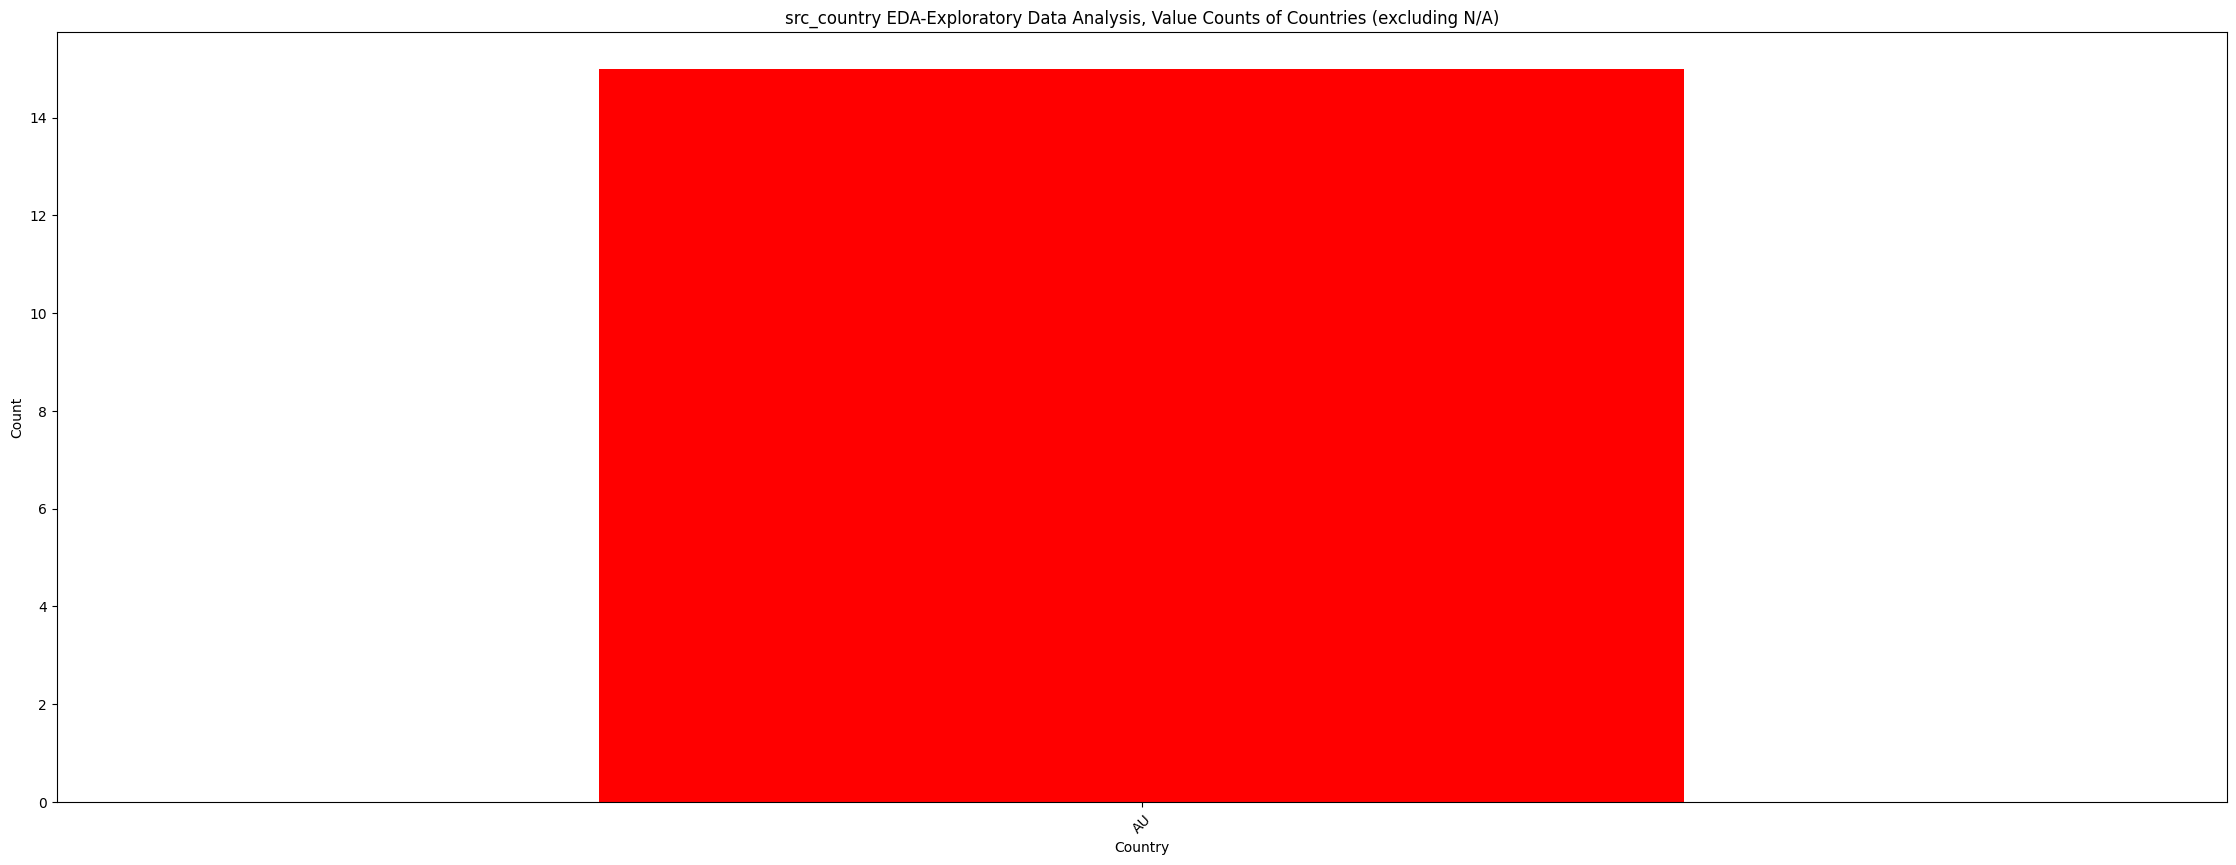

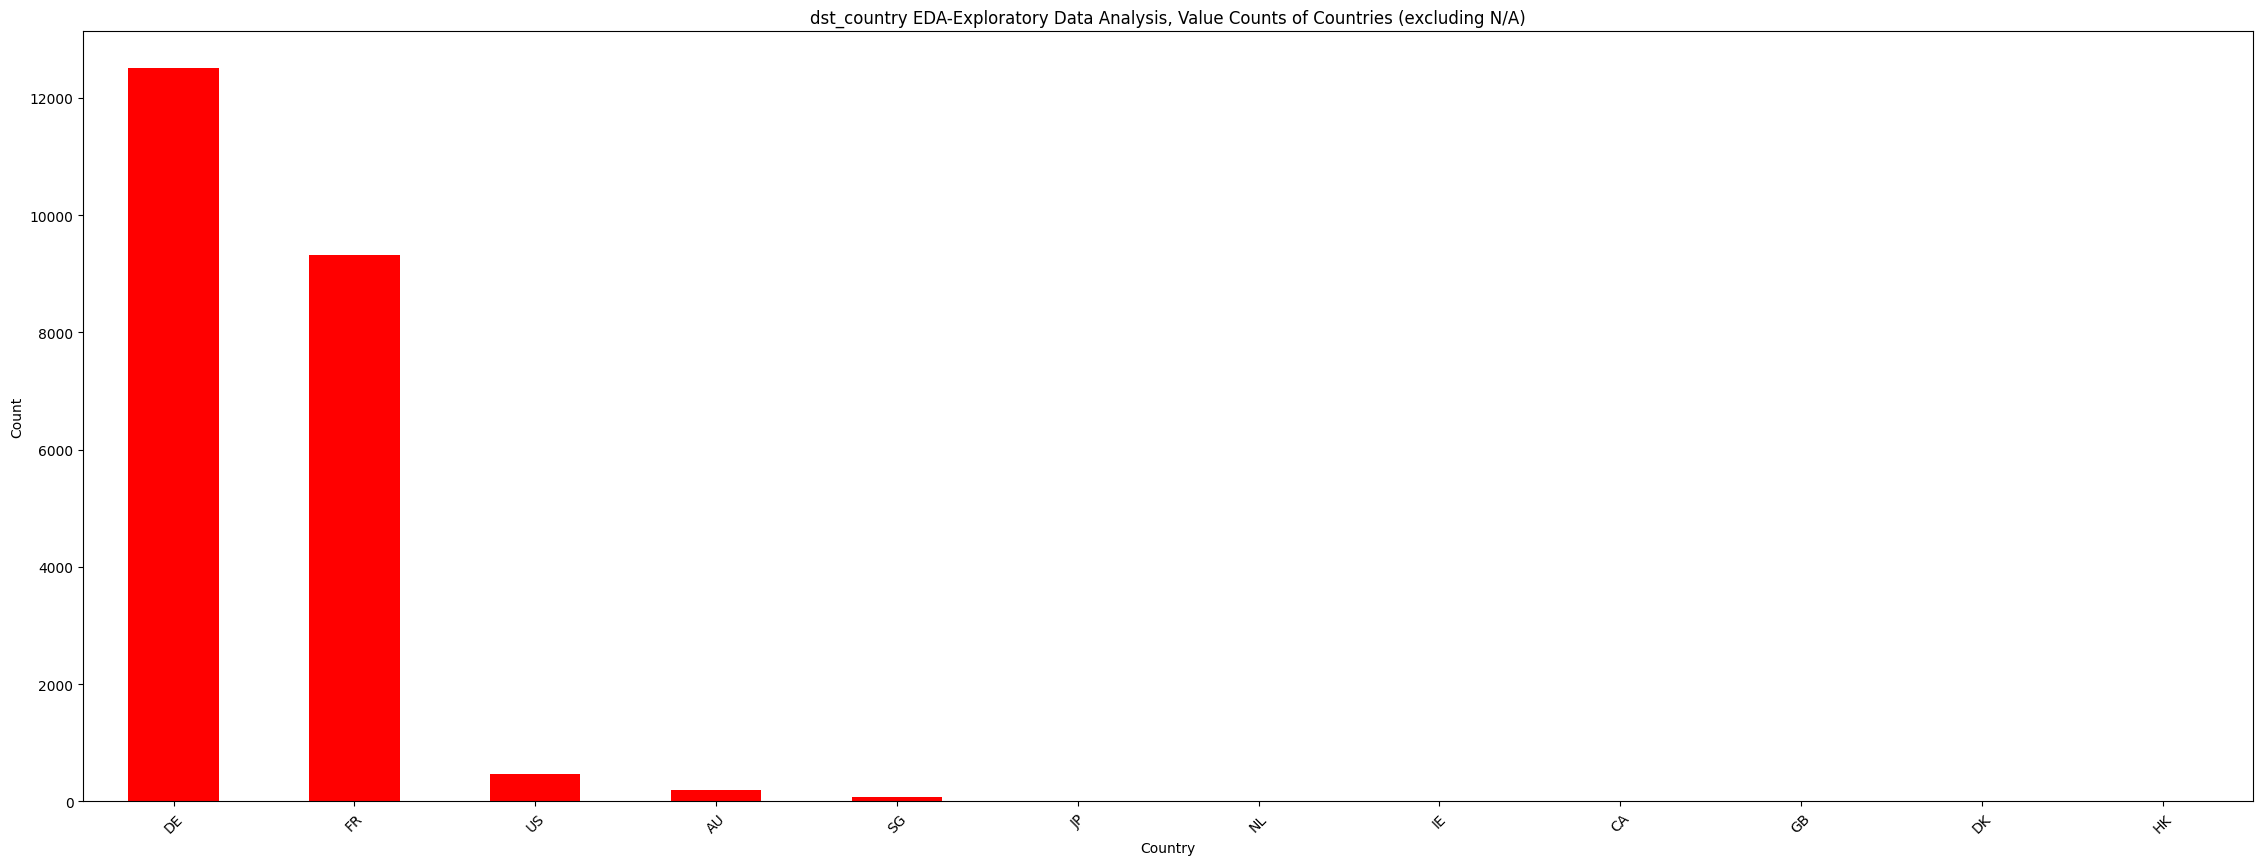

In [50]:
#Plots - visually representing traffic origination country and destination country to monitor red flags.
# Create a sub DataFrame where column 'label' has value 1 or in other words we filter and plot just attack - possitive records on the network dataframe
subattack_network = network[network['label'] == 1]

IP_source = ['src_country', 'dst_country']
for i in IP_source:
  country_counts = subattack_network[i][subattack_network[i] != 'N/A'].value_counts()

  # Create a bar plot
  plt.figure(figsize=(28, 10))
  country_counts.plot(kind='bar', color='red')
  plt.xlabel('Country')
  plt.ylabel('Count')
  #title_text = f"{i} {static_title}"
  title_text = f"{i} {'EDA-Exploratory Data Analysis, Value Counts of Countries (excluding N/A)'}"
  plt.title(title_text)
  plt.xticks(rotation=45)  # Rotate x-axis labels if needed
  plt.show()



In [51]:
#Dropping Columns, largely because they have "-" on overwhelming majority of entries which makes is ineligible for analysis or no value in imputing.
# (or) verbose to the extent there are so many unique values which makes is unnecessary. 28 fields seems to be eligible to be inclused for analysis.
net_df = network.drop(['src_ip', 'dst_ip', 'weird_notice', 'weird_addl', 'weird_name', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'ssl_cipher',
       'ssl_subject', 'dns_query', 'ssl_issuer', 'src_port', 'dst_port', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_established', 'ssl_resumed'], axis=1)

#Below code is used in EDA(exploratory data analysis to review what columns can be dropped for analysis.)
#list1 = net_df.columns
#for i in list1:
#  print ('#### field: ####', i)
#  print (net_df[i].value_counts())
#ISO 8601 Timestamps:   Prepping the column 'ts' which is in epoc seconds to human readable time stamps.
#YYYY-MM-DD HH:MM:SS (e.g., '2023-09-26 15:30:00') (Human readable Format)
net_df['date'] = pd.to_datetime(net_df['ts'], unit='s')
#print('Date stampe', net_df['date'])
net_df = net_df.set_index('date')
net_df = net_df.drop(['ts'], axis=1)
print(net_df.columns)
print(net_df.shape)



Index(['proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state',
       'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'label', 'type', 'src_country',
       'dst_country'],
      dtype='object')
(461043, 18)


In [52]:
#Below code is used in EDA(exploratory data analysis to review what columns can be dropped for analysis.)
net_df['service'] = net_df['service'].replace('-', 'Unknown')
#net_df['src_country'] = net_df['src_country'].replace('N/A', 'NULL')
#net_df['dst_country'] = net_df['src_country'].replace('N/A', 'NULL')
#EDA block code
#list1 = net_df.columns
#for i in list1:
#  print ('#### field: ####', i)
#  print (net_df[i].value_counts())
net_df.head()
#net_df.tail()


,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label,type,src_country,dst_country
date,,,,,,,,,,,,,,,,,,
2019-04-02 09:45:58,tcp,Unknown,80549.530260,1762852,41933215,OTH,0,252181,14911156,2,236,0,0,0,0,normal,DE,N/A
2019-04-02 09:45:58,udp,Unknown,0.000000,0,0,S0,0,1,63,0,0,0,0,0,0,normal,N/A,N/A
2019-04-02 09:45:59,tcp,Unknown,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0,normal,N/A,N/A
2019-04-02 09:45:59,tcp,Unknown,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0,normal,N/A,N/A
2019-04-02 09:46:02,udp,dns,0.000549,0,298,SHR,0,0,0,2,354,0,0,0,0,normal,N/A,N/A


In [53]:
#EDA initiative to understand data
#print(net_df['dns_qclass'].value_counts())
#print(net_df['dns_qtype'].value_counts())
#print(net_df['dns_rcode'].value_counts())
#dropping multiclass for initial analysis which is feature 'type' in net_df dataframe.
netsc_df = net_df.drop(['type', 'src_country',	'dst_country'], axis=1)
#etsc_df = net_df.drop(['type'], axis=1)
print(netsc_df.shape)
netsc_df.tail()

(461043, 15)


,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label
date,,,,,,,,,,,,,,,
2019-04-27 04:54:22,tcp,Unknown,0.000000,0,0,S0,0,1,60,0,0,0,0,0,1
2019-04-28 03:49:50,tcp,Unknown,0.000000,0,0,OTH,0,0,0,1,103,0,0,0,1
2019-04-28 07:30:03,tcp,Unknown,290.371539,101568,2592,OTH,0,108,108064,31,3832,0,0,0,1
2019-04-29 12:20:42,tcp,Unknown,23.190902,32,31,SF,0,8,411,7,395,0,0,0,1
2019-04-29 12:20:42,tcp,Unknown,22.872314,32,31,SF,0,8,411,6,343,0,0,0,1


In [39]:
print(netsc_df['conn_state'].value_counts())

SF        123512
S0        113495
OTH       111842
REJ        45036
SHR        22053
SH         18138
S1         13843
S3          6642
RSTR        2360
RSTRH       1724
RSTO        1518
S2           708
RSTOS0       172
Name: conn_state, dtype: int64


In [67]:
##
#establishing Baseline accuracy
##
Baccuracy = 0.0
print('Majority of network traffic is normal indicated by label 0, attach traffic is indicated by label 1')
print(netsc_df['label'].value_counts(normalize=True))
majority_class = netsc_df['label'].value_counts().idxmax()
baseline_predictions = [majority_class] * len(netsc_df['label'])
#Calculate the accuracy of the baseline model:
Baccuracy = accuracy_score(netsc_df['label'], baseline_predictions)
print("Baseline Accuracy:", Baccuracy)

Majority of network traffic is normal indicated by label 0, attach traffic is indicated by label 1
0    0.650699
1    0.349301
Name: label, dtype: float64
Baseline Accuracy: 0.6506985248664441


In [55]:
netsc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461043 entries, 2019-04-02 09:45:58 to 2019-04-29 12:20:42
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   proto         461043 non-null  object 
 1   service       461043 non-null  object 
 2   duration      461043 non-null  float64
 3   src_bytes     461043 non-null  int64  
 4   dst_bytes     461043 non-null  int64  
 5   conn_state    461043 non-null  object 
 6   missed_bytes  461043 non-null  int64  
 7   src_pkts      461043 non-null  int64  
 8   src_ip_bytes  461043 non-null  int64  
 9   dst_pkts      461043 non-null  int64  
 10  dst_ip_bytes  461043 non-null  int64  
 11  dns_qclass    461043 non-null  int64  
 12  dns_qtype     461043 non-null  int64  
 13  dns_rcode     461043 non-null  int64  
 14  label         461043 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 56.3+ MB


In [68]:
#'l1': L1 regularization (Lasso regularization)
X_train, X_test, y_train, y_test = train_test_split(netsc_df.drop(['label'], axis = 1), netsc_df['label'], random_state = 442,
                                                   stratify = netsc_df['label'])
lgr_accuracy = 0
selector = ''
#selector = ['src_country', 'dst_country', 'dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
selector = ['dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
ransformer = ''
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
extractor = ''
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))
lgr_pipe = ''
pipe_1_acc = ''
lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 5000))])

lgr_pipe.fit(X_train, y_train)

pipe_1_acc = lgr_pipe.score(X_test, y_test)
lgr_predictions = lgr_pipe.predict(X_test)
lgr_accuracy = accuracy_score(y_test, lgr_predictions)
print(lgr_pipe)
print("Baseline Accuracy:", Baccuracy)
print("Pipeline Accuracy:", lgr_accuracy)
print("lgr L1 score:", pipe_1_acc)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['dns_rcode', 'dns_qtype',
                                                   'dns_qclass', 'conn_state',
                                                   'service', 'proto'])])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=5000, random_state=42))])
Baseline Accuracy: 0.6506985248664441
Pipeline Accuracy: 0.8598571936734889
lgr L1 score: 0.8598571936734889


Pipeline Accuracy: 0.8598571936734889


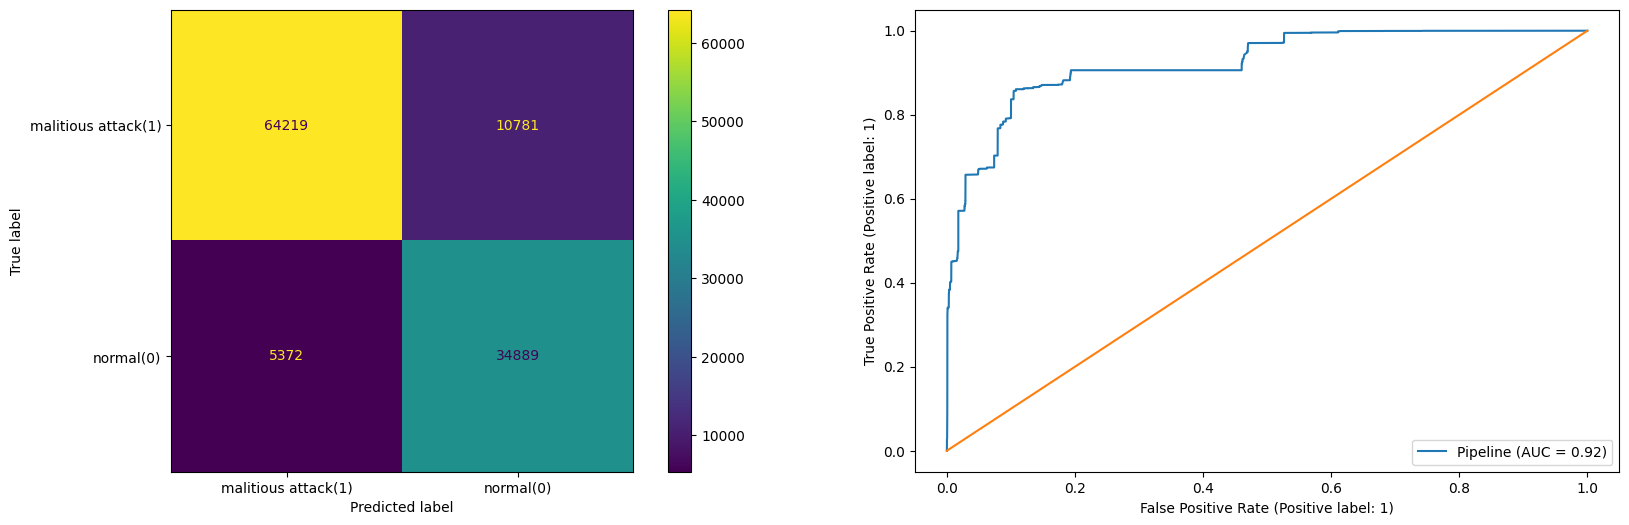

In [63]:
fp = ''
fn = ''
auc = ''

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0], display_labels = ['malitious attack(1)', 'normal(0)'])
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))
#     Confusion Matrix

#     |64219 | 10781
#  0  |(TN)  | (FP)
#   --------------     y-axis Truth
#     |5372  | 34889
#  1  |(FN)  | (TP)
#   --------------
#        0   |  1
#      (x-axis Predicted)
################################
#   (x,y) co-ordinates
#   TN(0,0) True negative (normal network traffic), model predicted not an attack 64219 and it was truely normal traffic
#   TP(1,1) True positive (network attack), model predicted an attack 34889 and it was truely an attack
#   FN(0,1) False negative Model predicted (normal network traffic) 5372, but was actually an attack.
#   FP(1,0) False possitive model predicted (network attack) 10781, but was actually normal.

# For our scenario we need to tweak the model to reduce the FN(False negative) to gain more model confidence.
# So when the model says normal it can not be an attack.  ( number 5372 at FN(0,1) needs to be reduced )
################################
lgr_predictions = lgr_pipe.predict(X_test)
accuracy = accuracy_score(y_test, lgr_predictions)
print("Pipeline Accuracy:", accuracy)
auc = float(round(accuracy, 2))
###############################
#Here's how you can use the ROC curve to minimize false negatives:
#Threshold Selection: The ROC curve illustrates the trade-off between sensitivity (true positive rate) and specificity (true negative rate)
#across different threshold settings. By adjusting the classification threshold, you can control the balance between false positives and false negatives.

#Desired Sensitivity: If your goal is to minimize false negatives (e.g., in a medical diagnosis or cyber threats where missing a positive case is costly), you can select
# a threshold that corresponds to a high sensitivity on the ROC curve. This threshold will maximize the true positive rate and minimize false negatives.

#Evaluate Trade-offs: Keep in mind that as you increase sensitivity (reduce false negatives), you may also increase false positives. The ROC curve helps
#you visualize and evaluate these trade-offs. You can choose a threshold that aligns with your specific requirements and risk tolerance.

#area Under the ROC Curve (AUC-ROC): The AUC-ROC value can also provide insights into the model's ability to minimize false negatives.
#A higher AUC-ROC indicates better discrimination between positive and negative classes, which generally means the model is better at minimizing false negatives.

#In summary, while the ROC curve itself does not directly minimize false negatives, it provides a visual representation of the model's sensitivity and its
#trade-off with specificity. You can use this information to select an appropriate threshold or evaluate the model's performance with respect to minimizing
#false negatives in your specific application.









In [69]:

#'l2': L2 regularization (Ridge regularization)

X_train, X_test, y_train, y_test = train_test_split(netsc_df.drop(['label'], axis = 1), netsc_df['label'], random_state = 442,
                                                   stratify = netsc_df['label'])
lgr_accuracy = 0
selector = ''
#selector = ['src_country', 'dst_country', 'dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
selector = ['dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
ransformer = ''
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
extractor = ''
extractor = SelectFromModel(LogisticRegression(penalty='l2', solver = 'liblinear' ,random_state = 42))
lgr_pipe2 = ''
pipe_2_acc = ''
lgr_pipe2 = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 5000))])

lgr_pipe2.fit(X_train, y_train)

pipe_2_acc = lgr_pipe2.score(X_test, y_test)
lgr_predictions2 = lgr_pipe2.predict(X_test)
lgr_accuracy2 = accuracy_score(y_test, lgr_predictions2)
print(lgr_pipe)
print("Baseline Accuracy:", Baccuracy)
print("Pipeline Accuracy:", lgr_accuracy2)
print("lgr L2 score:", pipe_2_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['dns_rcode', 'dns_qtype',
                                                   'dns_qclass', 'conn_state',
                                                   'service', 'proto'])])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=5000, random_state=42))])
Baseline Accuracy: 0.6506985248664441
Pipeline Accuracy: 0.8596489705971664
lgr L2 score: 0.8596489705971664
